**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import skimage
from os import listdir
import pickle
import numpy as np
import random
import os
import sys
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
module_path = os.path.abspath(os.path.join('../python/'))
if module_path not in sys.path:
    sys.path.append(module_path)   
from CarFindingPipeline import *
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from moviepy.editor import VideoFileClip
%matplotlib inline

Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
Writeup / README

1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  

You're reading it!

I first read all the the `vehicle` and `non-vehicle` images files and save them into a pickle file as done in the following cell.

In [2]:
vehicleFolder = '../data/vehicles/'
vehicleSubFolders = ['GTI_Far', 'GTI_Left', 'GTI_Right', 'KITTI_extracted']
nonvehicleFolder = '../data/non-vehicles/'
nonvehicleSubFolders = ['GTI', 'Extras']
vehicleData = list()
for folder in vehicleSubFolders:
    for files in listdir(vehicleFolder+folder):
        img  = cv2.imread(vehicleFolder + folder + '/' + files)
        vehicleData.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
nonvehicleData = list()
for folder in nonvehicleSubFolders:
    for files in listdir(nonvehicleFolder+folder):
        img = cv2.imread(nonvehicleFolder + folder + '/' + files)
        nonvehicleData.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
alldata = {"vehicle": np.array(vehicleData), "nonvehicle": np.array(nonvehicleData)}
with open('../data/alldata.p', 'wb') as f:
    pickle.dump(alldata, f)


Histogram of Oriented Gradients (HOG)

1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the following code cells of the IPython notebook.  

In the first cell, I show an example of one of each of the `vehicle` and `non-vehicle` classes:


We have 3403 vehicle samples and 6409 non vehicle samples.


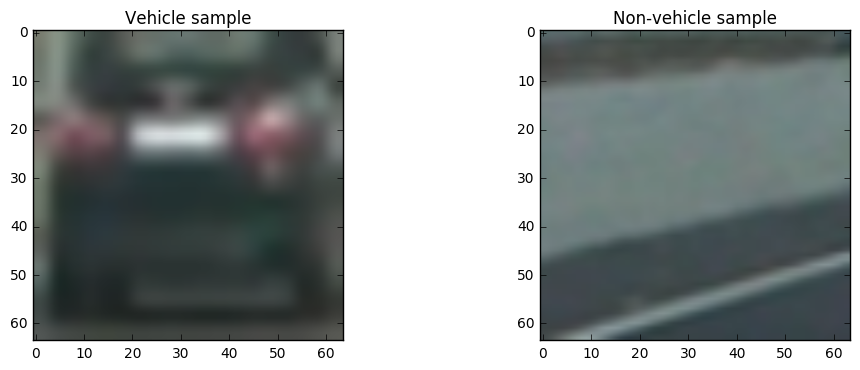

In [3]:
with open('../data/alldata.p', 'rb') as f:
    alldata = pickle.load(f)
vehicleData, nonvehicleData = alldata['vehicle'], alldata['nonvehicle']
numberOfVehicleSamples = len(vehicleData)
numberOfNonVehicleSamples = len(nonvehicleData)
print("We have {} vehicle samples and {} non vehicle samples.".format(numberOfVehicleSamples, numberOfNonVehicleSamples))
random.seed(100)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(vehicleData[random.randint(0,numberOfVehicleSamples)])
plt.title("Vehicle sample")
plt.subplot(1,2,2)
plt.imshow(nonvehicleData[random.randint(0,numberOfNonVehicleSamples)])
plt.title("Non-vehicle sample")

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the S channel in `HSV` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

(7, 7, 2, 2, 8)


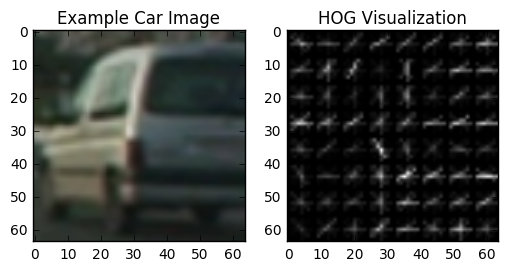

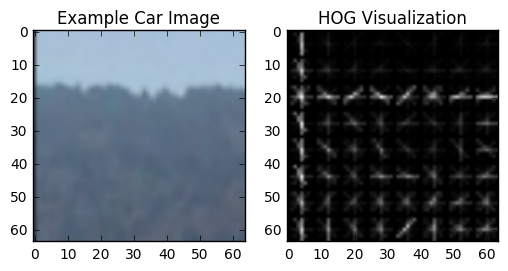

In [4]:
randomSampleForCar = random.randint(0,numberOfVehicleSamples)
img =  vehicleData[randomSampleForCar]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
# Define HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

randomSampleForNonCar = random.randint(0,numberOfNonVehicleSamples)
img =  nonvehicleData[randomSampleForNonCar]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
print(features.shape)

####2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and find YCrCb color space give me the best results.

####3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using both hog features and color features. Then I standarized the data by using ``StandardScaler`` in skilearn package. I used 20% data as testing data when training the classifier. The codes are given in the following cell.

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True# Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, None] # Min and max in y to search in slide_window()

car_features = extract_features(vehicleData, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicleData, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
2.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9847


###Sliding Window Search

####1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search window positions at scales =(1.0, 1.5, 2.0) with y postion between (350, 656) over the image and came up with this:

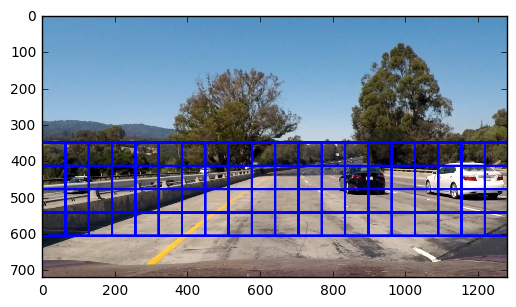

In [6]:
image = mpimg.imread('../test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 656], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

####2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

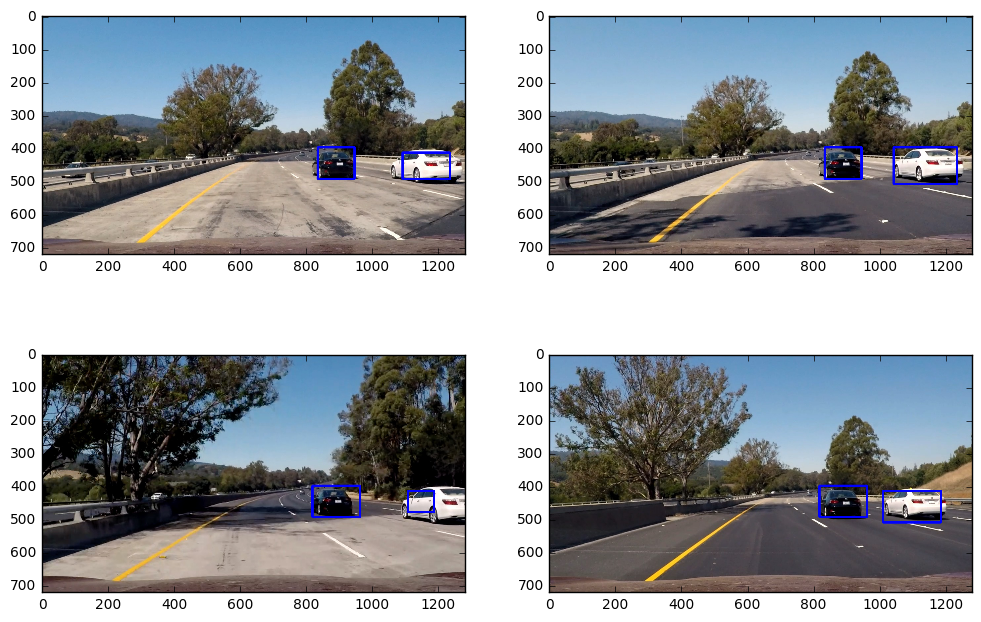

In [7]:
k = 1
plt.figure(figsize=(12,8))
for i in [1,4,5,6]:
    image = mpimg.imread('../test_images/test' + str(i) +'.jpg')
    pipeline = CarFindPipeline()
    plt.subplot(2,2,k)
    plt.imshow(pipeline.process_image(image, minArea=3600,thresholdPerFrame=9, buffersize=1, laneDetection=False))
    k += 1

### Video Implementation

####1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)

####2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then overlay the heatmaps nad threshold the overlayed heatmaps.

### Here are six frames and their corresponding heatmaps:

In [8]:
clip1 = VideoFileClip("../project_video.mp4", audio=False)
images = []
for i in range(990, 996):
    images.append(clip1.get_frame(i/1261.0*50.0))
classifierInfo = pickle.load(open("../results/classifier.p", "rb"))
svc = classifierInfo['classifier']
X_scaler = classifierInfo['X_scaler']
orient = classifierInfo['orient']
pix_per_cell = classifierInfo['pix_per_cell']
cell_per_block = classifierInfo['cell_per_block']
spatial_size = classifierInfo['spatial_size']
hist_bins = classifierInfo['hist_bins']
conv = 'RGB2YCrCb'
ystart=350
ystop=656
buffersize = 6
buffer_heat = np.zeros((buffersize, images[0].shape[0], images[1].shape[1])).astype(np.float)

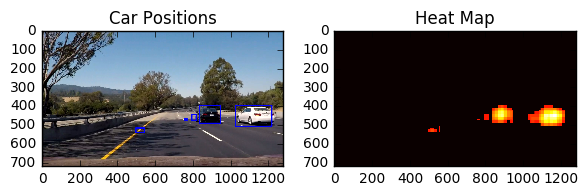

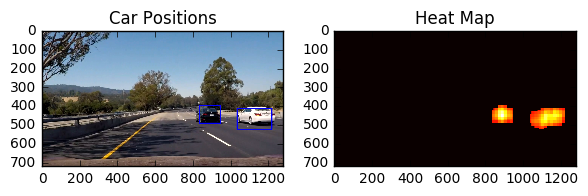

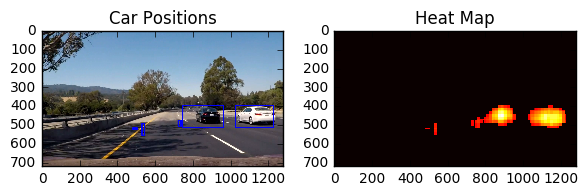

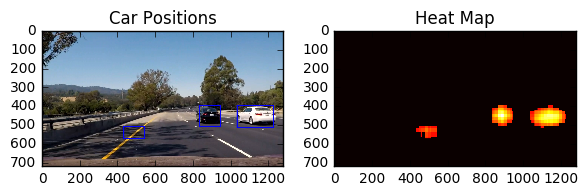

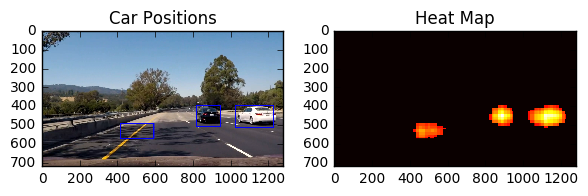

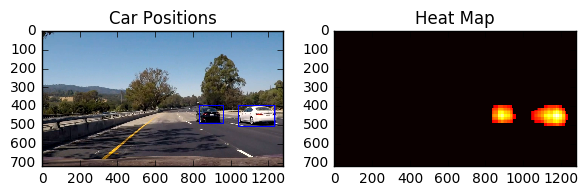

In [9]:
count = 0
for image in images:
    box_list = []
    for scale in [1, 1.5, 2]:
        out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient,
                                           pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                           conv)
        box_list.extend(bbox_list)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,9)
    buffer_heat[count, ] = heat
    count += 1
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels, minArea=100)
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    

### Here is the output on the integrated heatmap from all six frames and the resulting bounding boxes are drawn onto the last frame in the series:

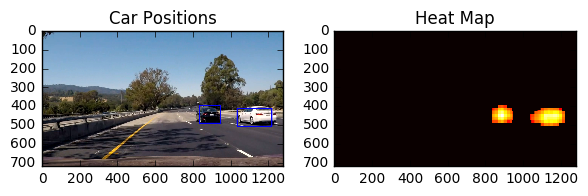

In [10]:
heat = apply_threshold(np.sum(buffer_heat, axis=0), 54)
# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(images[5]), labels, minArea=100)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

###Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Tuning the correct threshold and integrated heatmap size is tricky. I ended up choose a quite large buffer size to remove the false positive but it also seems reduce the robustness of identifying cars on all frames. In addition, I add the minimum box size to remove some small false positives. The current pipline may fail if there are some car not in the training set. So my pipeline may be improved after using a larger training dataset. Moreover, using a convolutional neural network based classifier should further improve the performance of my pipeline.